In [ ]:
# Librerias
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Problema
Resolver la ecuación diferencial

$$\begin{aligned}
-\Delta u &= f(x), \hspace{1cm} x \in \Omega =(1,0) \\
u|_{\partial \Omega} &= 0.
\end{aligned}$$
La Formulación variacional viene dada por
$$\int_{\Omega} \nabla u \nabla v \, dx - \int_{\partial \Omega} u\, v \, ds= \int_{\Omega} f\, v \, dx,$$
para todo $v \in H_{0}^{1}(\Omega)$. La integral sobre el borde en la expresión anterior puede ser omitida.


In [ ]:
def u(x):
    #return np.sin(np.pi * x)
    #return tf.sin(tf.constant(np.pi) * x)
    return np.sin(np.pi * x) * np.exp(10 * x - 10)


def f(x):
    #return -np.pi**2 * np.sin(np.pi * x)
    # return tf.constant(np.pi**2) * tf.sin(tf.constant(np.pi) * x)
    term1 = -tf.exp(10 * (x - 1))
    term2 = 20 * tf.constant(np.pi) * tf.cos(tf.constant(np.pi) * x)
    term3 = (10 - tf.constant(np.pi)) * (10 + tf.constant(np.pi)) * tf.sin(tf.constant(np.pi) * x)

    return term1 * (term2 + term3)


In [ ]:
# ARQUITECTURA DE LA RED NEURONAL:

def init_model(num_hidden_layers = 3, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1,)))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))

    model.add(tf.keras.layers.Dense(1))
    return model

# Instanciar el modelo:
model_1 = init_model()



In [ ]:
##############################################################################################
# CALCULO DEL RESIDUO
##############################################################################################
def r_i(u_model,f,x0,x1,x2):
    num_points = 2
    points, weights = np.polynomial.legendre.leggauss(num_points)

    ##############################################################################################
    ## INTEGRAL EN EL INTERVALO x0, x1:
    ##############################################################################################
    points1 = 0.5 * (x1 - x0) * points + 0.5 * (x1 + x0)
    ## Transforma a tensor el vector points:
    points_tf1 = tf.reshape(tf.convert_to_tensor(points1, dtype=tf.float32), (-1,1))
    weights_tf1 = tf.reshape(tf.convert_to_tensor(weights, dtype=tf.float32), (-1,1))

    # Calcular la derivada de u_model:
    with tf.GradientTape() as tape:
        tape.watch(points_tf1)
        u = u_model(points_tf1)
    du_dx1 = tape.gradient(u, points_tf1)   # derivada de la red con respecto a input x

    # Integrar Du en el intervalo x0, x1:
    Iu1 = 0
    for i in range(num_points):
      Iu1 += weights_tf1[i] * du_dx1[i]

    Iu1 = 0.5 * (x1 - x0) * Iu1 * (1/(x1 - x0))

    If1 = 0
    for i in range(num_points):
       If1 += weights_tf1[i] * f(points_tf1[i]) * (points_tf1[i] - x0) / (x1 - x0)

    If1 = 0.5 * (x1 - x0) * If1

    ##############################################################################################
    ## INTEGRAL EN EL INTERVALO x1, x2:
    ##############################################################################################
    points2 = 0.5 * (x2 - x1) * points + 0.5 * (x2 + x1)
    ## Transforma a tensor el vector points:
    points_tf2 = tf.reshape(tf.convert_to_tensor(points2, dtype=tf.float32), (-1,1))
    weights_tf2 = tf.reshape(tf.convert_to_tensor(weights, dtype=tf.float32), (-1,1))

    # Calcular la derivada de u_model:
    with tf.GradientTape() as tape:
        tape.watch(points_tf2)
        u = u_model(points_tf2)
    du_dx2 = tape.gradient(u, points_tf2)   # derivada de la red con respecto a input x

    # Integrar Du en el intervalo x1, x2:
    Iu2 = 0
    for i in range(num_points):
      Iu2 += weights_tf2[i] * du_dx2[i]

    Iu2 = 0.5 * (x2 - x1) * Iu2 * (-1/(x2 - x1))

    If2 = 0
    for i in range(num_points):
       If2 += weights_tf2[i] * f(points_tf2[i]) * (x2 - points_tf2[i]) / (x2 - x1)

    If2 = 0.5 * (x2 - x1) * If2

    ##############################################################################################
    ##############################################################################################

    Iu = Iu1 + Iu2
    If = If1 + If2
    return If - Iu

In [ ]:
r_i(model_1,f,0,0.5,1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0563435], dtype=float32)>

In [ ]:
N_points = 10 # Cantidad de puntos de la partición.
X_r = tf.linspace(0.0, 1.0, N_points)

# r = tf.zeros(N_points - 2, dtype=tf.float32)

# for i in range(tf.size(r).numpy()):
#     r_value = tf.squeeze(r_i(model_1, f, X_r[i], X_r[i+1], X_r[i+2]))
#     r = tf.tensor_scatter_nd_update(r, [[i]], [r_value])
#     print(r[i].numpy())

# # Imprimir el tensor r final
# print("Tensor r:", r.numpy())

# Loss = tf.reduce_mean(tf.square(r))
# print(Loss)

In [ ]:
# Función de pérdida
def Loss(model, X_r):
    r = tf.zeros(N_points - 2, dtype=tf.float32)

    # Convertir el bucle a una operación tensorial
    indices = tf.range(N_points - 2)
    for i in indices:
        r_value = tf.squeeze(r_i(model, f, X_r[i], X_r[i+1], X_r[i+2]))
        r = tf.tensor_scatter_nd_update(r, [[i]], [r_value])

    loss_r = tf.reduce_mean(tf.square(r))
    loss_bc =  tf.reduce_mean(tf.square(model(X_r[0:1]) - 0.0)) + tf.reduce_mean(tf.square(model(X_r[-1:]) - 0.0))
    loss = loss_r + loss_bc
    return loss

In [ ]:
# Derivada de la pérdida con respecto a los parámetros (pesos y sesgos) del modelo
def get_grad(model, X_r):
    with tf.GradientTape() as tape:
        loss = Loss(model, X_r)
    grad = tape.gradient(loss, model.trainable_variables)
    return grad, loss

# Instanciar el optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Paso de Descenso de Gradiente
@tf.function
def train_step(model, X_r):
    grad, loss = get_grad(model, X_r)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Inicializacion del modelo
model_1 = init_model()

# Estructura que guarda valores de la pérdida
hist = {'loss':[]}



In [ ]:
from time import time
# Número de Épocas
N = 5000

# Comienzo del tiempo
t0 = time()

for i in range(N + 1):
    loss = train_step(model_1, X_r)
    hist['loss'].append(loss.numpy())

    if i % 500 == 0:
        print(f'Epoch {i}, Loss: {loss.numpy()}')

Epoch 0, Loss: 0.48846471309661865
Epoch 500, Loss: 0.0034664366394281387
Epoch 1000, Loss: 0.00015119428280740976
Epoch 1500, Loss: 5.948815305600874e-05
Epoch 2000, Loss: 2.2405551135307178e-05
Epoch 2500, Loss: 7.189748430391774e-06
Epoch 3000, Loss: 1.9854333004332148e-06
Epoch 3500, Loss: 4.318530386626662e-07
Epoch 4000, Loss: 8.970303611022246e-08
Epoch 4500, Loss: 2.0205886741564427e-08
Epoch 5000, Loss: 1.8124427469956572e-07


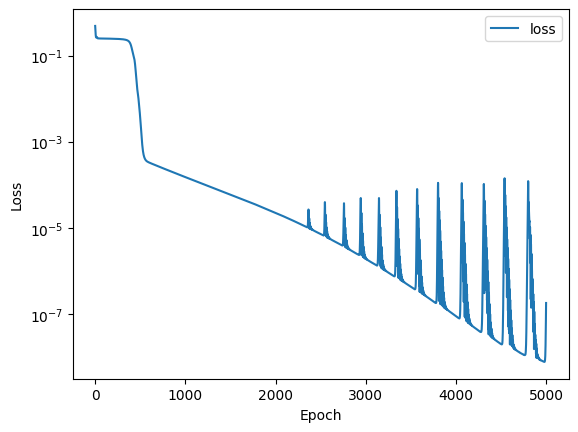

In [ ]:
plt.plot(hist['loss'], label='loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

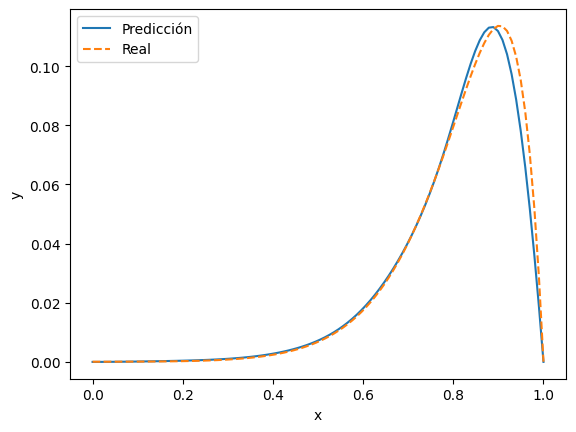

In [ ]:
# Grafica
x_min = 0.0
x_max = 1.0
x = np.linspace(x_min, x_max, 100)[:, None]
u_pred = model_1(x).numpy()
u_real = u(x)

plt.plot(x, u_pred, label='Predicción')
plt.plot(x, u_real, label='Real', linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()